In [1]:
import MySQLdb
from mysql_cred import mysql_user, mysql_passowrd, mysql_database
from pprint import pprint
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import datetime
import re

mysql_ip = '158.85.198.80'
mysql_port = 3306

def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecesasry plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()

In [2]:
con = MySQLdb.connect(mysql_ip, mysql_user, mysql_passowrd, mysql_database, port = mysql_port)

In [3]:
def exec_pd(query, printit = False):
    con = MySQLdb.connect(mysql_ip, mysql_user, mysql_passowrd, mysql_database, port = mysql_port)
    cursor = con.cursor()
    cursor.execute(query)
    result = cursor.fetchall()
    #pprint(result)
    df = pd.DataFrame.from_records(list(result))
    if printit:
        print df
    return df

def exec_list(query, printit = False):
    con = MySQLdb.connect(mysql_ip, mysql_user, mysql_passowrd, mysql_database, port = mysql_port)
    cursor = con.cursor()
    cursor.execute(query)
    result = cursor.fetchall()
    #pprint(result)
    df = list(result)
    if printit:
        print df
    return df

## rout_routeinfo and rout_routes

the information on routes does not change. i wrote unique values from this table to a textfile in order to avoid having to query the table later.

rout_routes contain exactly the same information is rout_routinfo.

In [62]:
routeinfo = pd.read_csv('routeinfo.txt', sep = '\t')
routeinfo

,sched_num,name,abbr,routeid,number,origin,destination,direction,color,holidays,num_stns,stations
0,35,Pittsburg/Bay Point - SFIA/Millbrae,PITT-SFIA,ROUTE 1,1,PITT,SFIA,NaN,#ffff33,1,26,"PITT,NCON,CONC,PHIL,WCRK,LAFY,ORIN,ROCK,MCAR,1..."
1,35,Millbrae/SFIA - Pittsburg/Bay Point,SFIA-PITT,ROUTE 2,2,SFIA,PITT,NaN,#ffff33,1,26,"MLBR,SFIA,SBRN,SSAN,COLM,DALY,BALB,GLEN,24TH,1..."
2,35,Fremont - Richmond,FRMT-RICH,ROUTE 3,3,FRMT,RICH,NaN,#ff9933,1,18,"FRMT,UCTY,SHAY,HAYW,BAYF,SANL,COLS,FTVL,LAKE,1..."
3,35,Richmond - Fremont,RICH-FRMT,ROUTE 4,4,RICH,FRMT,NaN,#ff9933,1,18,"RICH,DELN,PLZA,NBRK,DBRK,ASHB,MCAR,19TH,12TH,L..."
4,35,Fremont - Daly City,FRMT-DALY,ROUTE 5,5,FRMT,DALY,NaN,#339933,0,19,"FRMT,UCTY,SHAY,HAYW,BAYF,SANL,COLS,FTVL,LAKE,W..."
5,35,Daly City - Fremont,DALY-FRMT,ROUTE 6,6,DALY,FRMT,NaN,#339933,0,19,"DALY,BALB,GLEN,24TH,16TH,CIVC,POWL,MONT,EMBR,W..."
6,35,Richmond - Daly City/Millbrae,RICH-MLBR,ROUTE 7,7,RICH,MLBR,NaN,#ff0000,0,23,"RICH,DELN,PLZA,NBRK,DBRK,ASHB,MCAR,19TH,12TH,W..."
7,35,Millbrae/Daly City - Richmond,MLBR-RICH,ROUTE 8,8,MLBR,RICH,NaN,#ff0000,0,23,"MLBR,SBRN,SSAN,COLM,DALY,BALB,GLEN,24TH,16TH,C..."
8,35,Dublin/Pleasanton - Daly City,DUBL-DALY,ROUTE 11,11,DUBL,DALY,NaN,#0099cc,1,17,"DUBL,WDUB,CAST,BAYF,SANL,COLS,FTVL,LAKE,WOAK,E..."
9,35,Daly City - Dublin/Pleasanton,DALY-DUBL,ROUTE 12,12,DALY,DUBL,NaN,#0099cc,1,17,"DALY,BALB,GLEN,24TH,16TH,CIVC,POWL,MONT,EMBR,W..."


###list of routes and stations

In [63]:
routes = routeinfo.number.values
routes

array([ 1,  2,  3,  4,  5,  6,  7,  8, 11, 12, 19, 20])

In [64]:
st = routeinfo.stations.values
stations = []
for s in st:
    if len(s) > 0:
        stations += (s.split(','))

stations = list(set(stations))
stations = np.asarray(stations)
stations

array(['SHAY', 'FTVL', 'NCON', 'COLS', 'WCRK', 'WOAK', 'CONC', 'CAST',
       'ORIN', 'SFIA', 'WDUB', 'DALY', 'EMBR', 'CIVC', 'SBRN', 'HAYW',
       'LAFY', 'DBRK', '12TH', 'PHIL', 'PITT', 'NBRK', 'MONT', 'POWL',
       'ROCK', 'SANL', '16TH', 'FRMT', 'BALB', 'DELN', 'MCAR', 'DUBL',
       '24TH', 'PLZA', 'MLBR', 'GLEN', 'BAYF', 'LAKE', 'ASHB', 'UCTY',
       '19TH', 'COLM', 'RICH', 'SSAN', 'OAKL'], 
      dtype='|S4')

##sched_special

this can make things pretty complicated. i grabbed all unique information and the earliest that information was available. we see below that some the information is pretty crucial: scheduled delays and no train service to name a few. more processing needs to be done to clean the data up. we need to come back to this later. 

In [77]:
sched_special = exec_pd('select min(fetchtime) as min_fetchtime, start_date, start_time, \
        end_date, end_time, text_, orig, dest, day_of_week, routes_affected \
        from sched_special group by start_date, start_time, end_date, end_time, \
        text_, orig, dest, day_of_week, routes_affected order by min_fetchtime')
sched_special.columns = ['min_fetchtime', 'start_date', 'start_time', 'end_date', 'end_time', \
                        'text_', 'orig', 'dest', 'day_of_week', 'routes_affected']
sched_special

,min_fetchtime,start_date,start_time,end_date,end_time,text_,orig,dest,day_of_week,routes_affected
0,2015-06-04 01:43:04.919920,07/05/2015,06:00,07/05/2015,15:00,Delays on Pittsburg/Bay Point line,None,None,0,"ROUTE 1, ROUTE 2"
1,2015-06-04 01:43:04.919920,07/12/2015,00:01,07/12/2015,12:00,Bus bridge between Fruitvale and Coliseum,None,None,None,"ROUTE 1, ROUTE 2, ROUTE 3, ROUTE 4, ROUTE 5, R..."
2,2015-06-04 01:43:04.919920,07/11/2015,00:01,07/11/2015,23:59,Bus bridge between Fruitvale and Coliseum,None,None,None,"ROUTE 1, ROUTE 2, ROUTE 3, ROUTE 4, ROUTE 5, R..."
3,2015-06-04 01:43:04.919920,12/09/2014,23:00,12/31/2015,04:00,AC Transit is running enhanced late night bus ...,None,None,"0, 1, 2, 3, 4, 5, 6","ROUTE 1, ROUTE 2, ROUTE 3, ROUTE 4, ROUTE 5, R..."
4,2015-06-04 01:43:04.919920,06/21/2015,06:00,06/21/2015,15:00,Delays on Pittsburg/Bay Point line,None,None,0,"ROUTE 1, ROUTE 2"
5,2015-06-04 01:43:04.919920,06/20/2015,06:00,06/20/2015,15:00,Delays on Pittsburg/Bay Point line,None,None,6,"ROUTE 1, ROUTE 2"
6,2015-06-04 01:43:04.919920,06/14/2015,00:01,06/14/2015,23:59,Bus bridge between Fruitvale and Coliseum,None,None,None,"ROUTE 1, ROUTE 2, ROUTE 3, ROUTE 4, ROUTE 5, R..."
7,2015-06-04 01:43:04.919920,06/07/2015,00:01,06/07/2015,12:00,Bus bridge between Fruitvale and Coliseum Station,None,None,None,"ROUTE 1, ROUTE 2, ROUTE 3, ROUTE 4, ROUTE 5, R..."
8,2015-06-04 01:43:04.919920,06/06/2015,00:01,06/06/2015,23:59,Bus bridge between Fruitvale and Coliseum Station,None,None,None,"ROUTE 1, ROUTE 2, ROUTE 3, ROUTE 4, ROUTE 5, R..."
9,2015-06-04 01:43:04.919920,06/13/2015,00:01,06/13/2015,23:59,Bus bridge between Fruitvale and Coliseum,None,None,None,"ROUTE 1, ROUTE 2, ROUTE 3, ROUTE 4, ROUTE 5, R..."


##adv_count

count of number trains active. below i look at data in one week, and train the count as a function of time for each day of the week.

In [80]:
exec_pd('describe adv_count')

,0,1,2,3,4,5
0,uid,bigint(20),NO,PRI,None,auto_increment
1,fetchtime,varchar(26),YES,,None,
2,date,varchar(10),YES,,None,
3,time,varchar(15),YES,,None,
4,traincount,smallint(6),YES,,None,


In [176]:
adv_count = exec_pd('select distinct date, time, traincount from adv_count')
adv_count.columns = ['date', 'time', 'traincount']
adv_count.shape

(63667, 3)

In [182]:
adv_count['date_time'] = adv_count.date + ' ' + adv_count.time
adv_count.date_time = pd.to_datetime(adv_count.date_time, format = "%m/%d/%Y %H:%M:%S %p %Z").astype(datetime.datetime)
adv_count['time_time'] = pd.to_datetime(adv_count.time, format = "%H:%M:%S %p %Z").astype(datetime.datetime)
adv_count = adv_count.sort('date_time')

In [183]:
adv_count.head()

,date,time,traincount,date_time,time_time
12104,06/03/2015,23:43:00 PM PDT,24,2015-06-03 23:43:00,1900-01-01 23:43:00
12105,06/03/2015,23:44:00 PM PDT,23,2015-06-03 23:44:00,1900-01-01 23:44:00
12106,06/03/2015,23:45:00 PM PDT,23,2015-06-03 23:45:00,1900-01-01 23:45:00
12107,06/03/2015,23:46:00 PM PDT,23,2015-06-03 23:46:00,1900-01-01 23:46:00
12109,06/03/2015,23:47:00 PM PDT,22,2015-06-03 23:47:00,1900-01-01 23:47:00


In [188]:
ac_oneweek =adv_count[(adv_count['date'] < '06/29/2015') & (adv_count['date'] > '06/21/2015')]
ac_monday = ac_oneweek[ac_oneweek['date'] == '06/22/2015']
ac_tuesday = ac_oneweek[ac_oneweek['date'] == '06/23/2015']
ac_wednesday = ac_oneweek[ac_oneweek['date'] == '06/24/2015']
ac_thursday = ac_oneweek[ac_oneweek['date'] == '06/25/2015']
ac_friday = ac_oneweek[ac_oneweek['date'] == '06/26/2015']
ac_saturday = ac_oneweek[ac_oneweek['date'] == '06/27/2015']
ac_sunday = ac_oneweek[ac_oneweek['date'] == '06/28/2015']

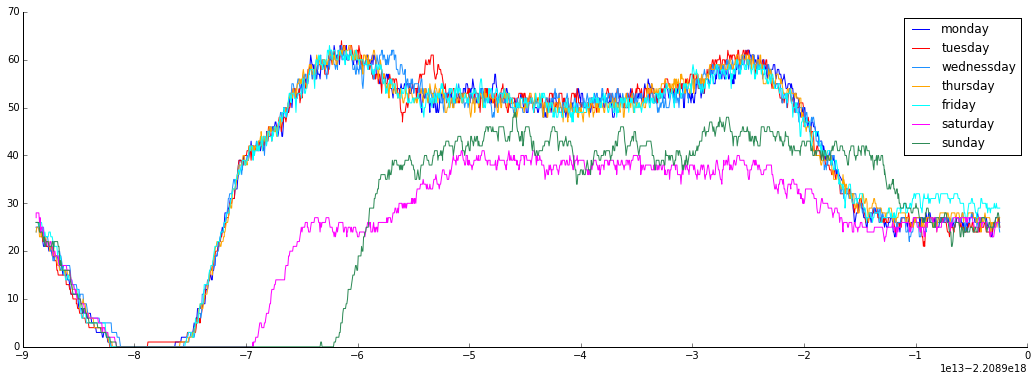

nice data


In [212]:
fig = plt.figure(figsize=(18, 6))
ax = fig.add_subplot(111)
#dt = mpl.dates.datestr2num(ac_monday.time)
ax.plot(ac_monday.time_time, ac_monday.traincount, label = 'monday')
ax.plot(ac_tuesday.time_time, ac_tuesday.traincount, label = 'tuesday', color = 'red')
ax.plot(ac_wednesday.time_time, ac_wednesday.traincount, label = 'wednessday', color = 'dodgerblue')
ax.plot(ac_thursday.time_time, ac_thursday.traincount, label = 'thursday', color = 'orange')
ax.plot(ac_friday.time_time, ac_friday.traincount, label = 'friday', color = 'cyan')
ax.plot(ac_saturday.time_time, ac_saturday.traincount, label = 'saturday', color = 'magenta')
ax.plot(ac_sunday.time_time, ac_sunday.traincount, label = 'sunday', color = 'seagreen')

plt.legend()
remove_border()
plt.show()
print 'nice data'

looking at data for the entire length of time we have been collecting, we see a couple of interesting outlier behaviors: in the second full week on friday we see a abnormally high activity. it turns out this corresponds to the warriors championship parade (june 19). the following sunday (june 28) we see another unusually high volume of trains, this time corresponding the pride parade in sf. the following weekend on saturday (july 4) we see lower than normal volume on independence day as many people go out of town.
There is also a hugh spike (actually 2 of them) on july 8. it appears this is just bad data (see below).

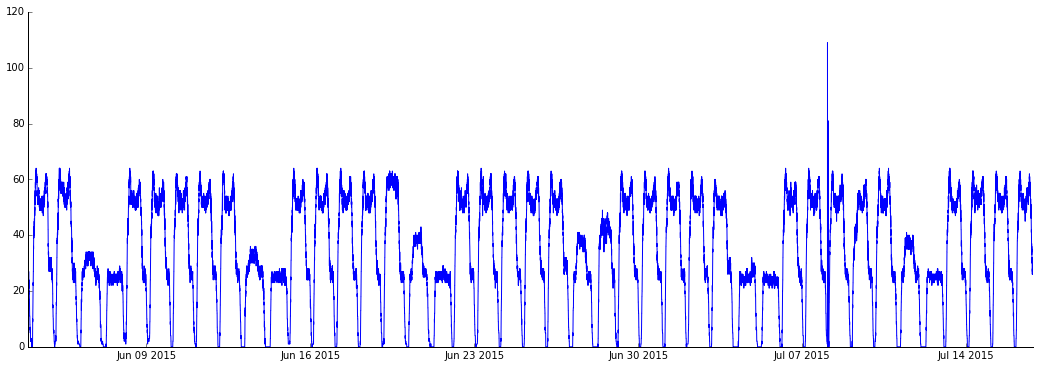

showing data from 06/03/2015 to 07/16/2015


In [216]:
plt.figure(figsize=(18, 6))
plt.plot(adv_count.date_time, adv_count.traincount)
remove_border()
plt.show()
print "showing data from " + str(min(adv_count.date)) + " to " + str(max(adv_count.date))

In [206]:
adv_count[adv_count['traincount'] > 80]

,date,time,traincount,date_time,time_time
50693,07/08/2015,02:32:00 AM PDT,109,2015-07-08 02:32:00,1900-01-01 02:32:00
50736,07/08/2015,03:15:00 AM PDT,81,2015-07-08 03:15:00,1900-01-01 03:15:00


In [208]:
print adv_count[adv_count['time'] == '02:32:00 AM PDT'].groupby('traincount').date.count()
print
print adv_count[adv_count['time'] == '03:15:00 AM PDT'].groupby('traincount').date.count()

traincount
0             31
1              5
2              4
3              2
109            1
Name: date, dtype: int64

traincount
0             28
1              9
2              5
81             1
Name: date, dtype: int64


##adv_elev

In [219]:
print list(exec_pd('describe adv_elev')[0])

['uid', 'fetchtime', 'date', 'time', 'id', 'station', 'type', 'description', 'posted', 'expires']


In [221]:
exec_pd('select * from adv_elev limit 5')

,0,1,2,3,4,5,6,7,8,9
0,1,2015-06-29 00:00:26.629730,06/28/2015,21:59:00 PM PDT,132159,BART,ELEVATOR,There are two elevators out of service at this...,Sun Jun 28 2015 08:07 PM PDT,None
1,2,2015-06-29 00:00:48.807348,06/28/2015,22:00:00 PM PDT,132159,BART,ELEVATOR,There are two elevators out of service at this...,Sun Jun 28 2015 08:07 PM PDT,None
2,3,2015-06-29 00:01:18.836357,06/28/2015,22:00:00 PM PDT,132159,BART,ELEVATOR,There are two elevators out of service at this...,Sun Jun 28 2015 08:07 PM PDT,None
3,4,2015-06-29 00:01:48.865358,06/28/2015,22:01:00 PM PDT,132159,BART,ELEVATOR,There are two elevators out of service at this...,Sun Jun 28 2015 08:07 PM PDT,None
4,5,2015-06-29 00:02:18.894405,06/28/2015,22:01:00 PM PDT,132159,BART,ELEVATOR,There are two elevators out of service at this...,Sun Jun 28 2015 08:07 PM PDT,None


In [224]:
adv_elev = exec_pd('select * from adv_elev')
adv_elev.columns = ['uid', 'fetchtime', 'date', 'time', 'id', 'station', 'type', 'description', 'posted', 'expires']

some of the columns (station, type, and expires) do not provide any information. we can remove these from our data collection in the future. date and time columns correpond to date and time at the time of call, which is redundant given that we record fetchtime. we can remove these columns as well.

In [248]:
stations = adv_elev.groupby('station').station.count()
print stations
print
types = adv_elev.groupby('type').station.count()
print types
print
expires = adv_elev.groupby('expires').station.count()
print expires

station
BART       124330
Null            6
Name: station, dtype: int64

type
ELEVATOR    124330
Null             6
Name: station, dtype: int64

expires
Null       6
Name: station, dtype: int64


In [249]:
adv_elev[adv_elev.station == 'Null']

,uid,fetchtime,date,time,id,station,type,description,posted,expires
27872,27873,2015-06-18 02:19:36.355139,06/18/2015,00:19:00 AM PDT,Null,Null,Null,Attention passengers: All elevators are in ser...,Null,Null
27873,27874,2015-06-18 02:20:06.365497,06/18/2015,00:19:00 AM PDT,Null,Null,Null,Attention passengers: All elevators are in ser...,Null,Null
27874,27875,2015-06-18 02:20:36.394703,06/18/2015,00:20:00 AM PDT,Null,Null,Null,Attention passengers: All elevators are in ser...,Null,Null
27875,27876,2015-06-18 02:21:06.423959,06/18/2015,00:20:00 AM PDT,Null,Null,Null,Attention passengers: All elevators are in ser...,Null,Null
27876,27877,2015-06-18 02:21:36.453213,06/18/2015,00:21:00 AM PDT,Null,Null,Null,Attention passengers: All elevators are in ser...,Null,Null
27877,27878,2015-06-18 02:22:06.482424,06/18/2015,00:21:00 AM PDT,Null,Null,Null,Attention passengers: All elevators are in ser...,Null,Null


6 consecutive calls gave null values for a number of variables. this does impact us, however, since they all correspond to the case where there are no elevators out of service. later we see that we dont even really need these columns.

In [251]:
adv_elev = adv_elev[['uid', 'fetchtime', 'id', 'description', 'posted']]
adv_elev.head()

,uid,fetchtime,id,description,posted
23261,23262,2015-06-04 01:43:04.919920,130816,There is one elevator out of service at this t...,Wed Jun 03 2015 10:08 PM PDT
23262,23263,2015-06-04 01:43:34.940328,130816,There is one elevator out of service at this t...,Wed Jun 03 2015 10:08 PM PDT
23263,23264,2015-06-04 01:44:04.952860,130816,There is one elevator out of service at this t...,Wed Jun 03 2015 10:08 PM PDT
23264,23265,2015-06-04 01:44:34.981868,130816,There is one elevator out of service at this t...,Wed Jun 03 2015 10:08 PM PDT
23265,23266,2015-06-04 01:45:05.010830,130816,There is one elevator out of service at this t...,Wed Jun 03 2015 10:08 PM PDT


below we see the posted column corresponds to min_fetchtime, which makes sense. given that we most likely will join the different tables in fetchtime, we can remove this column as well. id is also useless for our purposes.

In [350]:
adv_elev = exec_pd('select min(fetchtime) as min_fetchtime, id, description, posted \
from adv_elev group by id, description, posted')
adv_elev.columns = ['min_fetchtime', 'id', 'description', 'posted']
adv_elev = adv_elev.sort('min_fetchtime')

In [351]:
adv_elev.head()

,min_fetchtime,id,description,posted
0,2015-06-04 01:43:04.919920,130816,There is one elevator out of service at this t...,Wed Jun 03 2015 10:08 PM PDT
1,2015-06-04 06:05:46.322038,130817,There are no elevators out of service at this ...,Thu Jun 04 2015 04:04 AM PDT
2,2015-06-04 06:38:17.735498,130818,There is one elevator out of service at this t...,Thu Jun 04 2015 04:37 AM PDT
3,2015-06-04 13:25:33.868372,130828,There are no elevators out of service at this ...,Thu Jun 04 2015 11:24 AM PDT
4,2015-06-05 10:42:23.369006,130912,There are no elevators out of service at this ...,Fri Jun 05 2015 08:42 AM PDT


In [425]:
adv_elev = exec_pd('select min(fetchtime) as min_fetchtime, description \
from adv_elev group by description')
adv_elev.columns = ['min_fetchtime', 'description']
adv_elev = adv_elev.sort('min_fetchtime')

In [426]:
desc = list(adv_elev.description.unique())
print len(desc)
desc[:5]

137


['There is one elevator out of service at this time:  Coliseum Platform Elevator.  Thank you.',
 'There are no elevators out of service at this time.  Thank you.',
 'There is one elevator out of service at this time:  19th St. Oakland Street Elevator.  Thank you.',
 'There is one elevator out of service at this time:  Berkeley Street Elevator.  Thank you.',
 'There is one elevator out of service at this time:  MacArthur S.F./Fremont Platform Elevator.  Thank you.']

building elevator features would require doing text processing to identify which stations have elevators that are out. this might not be the best use of time at this point, especially given that it this might not be a significantly predictive feature for delays. we can come back to this later if there is time.

In [427]:
print "descriptions without 'out of service at this time'"
print [x for x in desc if 'out of service at this time' not in x.lower()]
print
print "descriptions with 'in service'"
print [x for x in desc if 'in service'in x.lower()]

descriptions without 'out of service at this time'
['Attention passengers: All elevators are in service. Thank You.', 'ALL STATION ELEVATORS ARE IN SERVICE.']

descriptions with 'in service'
['Attention passengers: All elevators are in service. Thank You.', 'ALL STATION ELEVATORS ARE IN SERVICE.']


two simple rules can explain how many elevators are out: 
- look for word after is/are: 
    - if a number, then that number
    - if no or in, then zero

In [445]:
num_dict = {'no': 0, 'in':0, 'one': 1, 'two': 2, 'three': 3, 'four': 4, 'five': 5, 'six': 6, 'seven': 7}

desc = list(adv_elev.description)
elevs_out = []
for t in desc:
    elevs_out.append(num_dict[re.search('(is|are) (.*?) ', str(t.lower())).group(2)])

adv_elev['elevs_out'] = elevs_out

hours = list(adv_elev.min_fetchtime_dt.map(lambda x: int(x.strftime('%H'))))
adv_elev['hours'] = hours

adv_elev.head(5)

,min_fetchtime,description,elevs_out,min_fetchtime_dt,hours
108,2015-06-04 01:43:04.919920,There is one elevator out of service at this t...,1,2015-06-04 01:43:04.919920,1
11,2015-06-04 06:05:46.322038,There are no elevators out of service at this ...,0,2015-06-04 06:05:46.322038,6
100,2015-06-04 06:38:17.735498,There is one elevator out of service at this t...,1,2015-06-04 06:38:17.735498,6
104,2015-06-05 11:39:25.606226,There is one elevator out of service at this t...,1,2015-06-05 11:39:25.606226,11
120,2015-06-05 14:24:31.743054,There is one elevator out of service at this t...,1,2015-06-05 14:24:31.743054,14


In [446]:
adv_elev['min_fetchtime_dt'] = pd.to_datetime(adv_elev.min_fetchtime, format = "%Y-%m-%d %H:%M:%S.%f").astype(datetime.datetime)

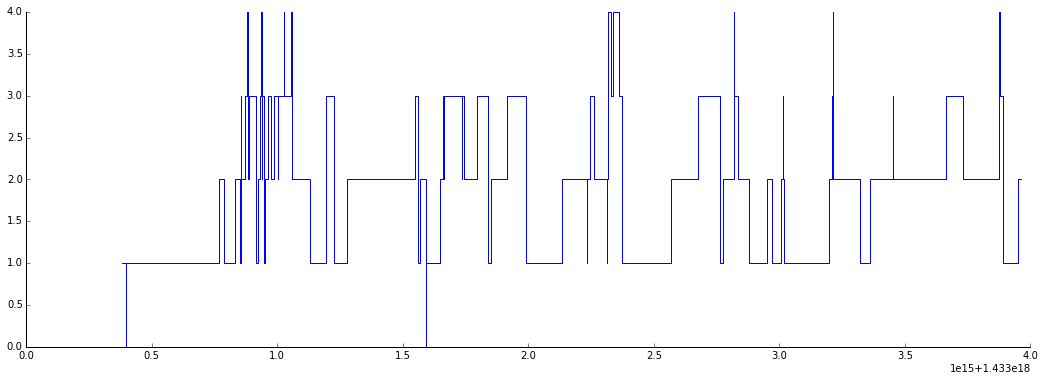

showing data from 2015-06-04 01:43:04.919920 to 2015-07-15 12:44:57.857593


In [455]:
plt.figure(figsize=(18, 6))
plt.step(adv_elev.min_fetchtime_dt, adv_elev.elevs_out, where='post')
#plt.plot(adv_elev.min_fetchtime_dt, adv_elev.min_fetchtime_dt.map(lambda x: x.strftime('%H')))

remove_border()
plt.show()
print "showing data from " + str(min(adv_elev.min_fetchtime_dt)) + " to " + str(max(adv_elev.min_fetchtime_dt))

<type 'int'>


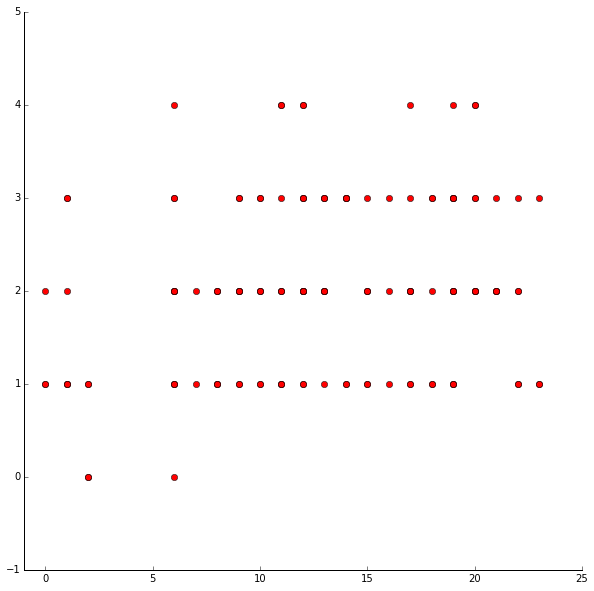

showing data from 2015-06-04 01:43:04.919920 to 2015-07-15 12:44:57.857593


In [480]:
plt.figure(figsize=(10, 10))
plt.plot(adv_elev.hours, adv_elev.elevs_out, 'ro')
plt.ylim([-1, 5])
plt.xlim([-1, 25])

remove_border()
plt.show()
print "showing data from " + str(min(adv_elev.min_fetchtime_dt)) + " to " + str(max(adv_elev.min_fetchtime_dt))

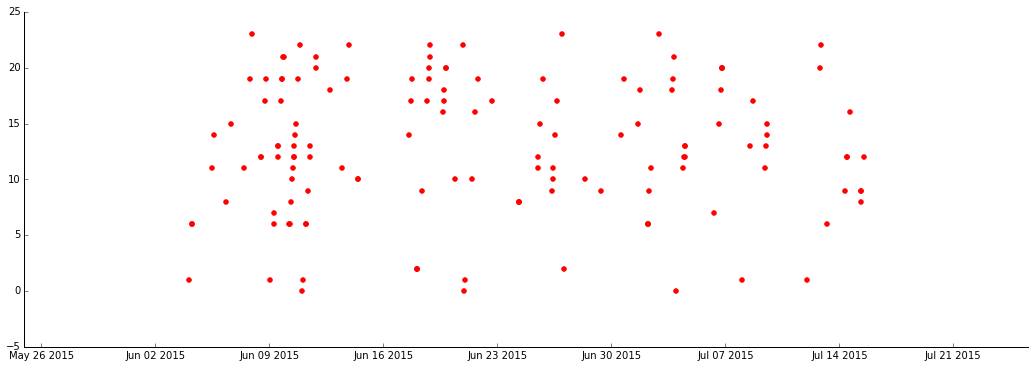

showing data from 2015-06-04 01:43:04.919920 to 2015-07-15 12:44:57.857593


In [438]:
plt.figure(figsize=(18, 6))

hours = list(adv_elev.min_fetchtime_dt.map(lambda x: x.strftime('%H')))
times = list(adv_elev.min_fetchtime_dt)


plt.scatter(times, hours, color = 'red')
remove_border()
plt.show()
print "showing data from " + str(min(adv_elev.min_fetchtime_dt)) + " to " + str(max(adv_elev.min_fetchtime_dt))

##adv_bsa

In [306]:
print list(exec_pd('describe adv_bsa')[0])

['uid', 'fetchtime', 'date', 'time', 'id', 'station', 'type', 'description', 'posted', 'expires']


In [309]:
adv_bsa = exec_pd('select * from adv_bsa')
adv_bsa.columns = ['uid', 'fetchtime', 'date', 'time', 'id', 'station', 'type', 'description', 'posted', 'expires']
adv_bsa.head(5)

,uid,fetchtime,date,time,id,station,type,description,posted,expires
0,1,2015-06-29 00:00:26.629730,06/28/2015,21:59:00 PM PDT,Null,Null,Null,No delays reported.,Null,Null
1,2,2015-06-29 00:00:48.807348,06/28/2015,22:00:00 PM PDT,Null,Null,Null,No delays reported.,Null,Null
2,3,2015-06-29 00:01:18.836357,06/28/2015,22:00:00 PM PDT,Null,Null,Null,No delays reported.,Null,Null
3,4,2015-06-29 00:01:48.865358,06/28/2015,22:01:00 PM PDT,Null,Null,Null,No delays reported.,Null,Null
4,5,2015-06-29 00:02:18.894405,06/28/2015,22:01:00 PM PDT,Null,Null,Null,No delays reported.,Null,Null


In [315]:
print adv_bsa.groupby('station').station.count()
print
print adv_bsa.groupby('type').station.count()
print
print adv_bsa.groupby('expires').station.count()
print
no_delay = adv_bsa[adv_bsa['description'] == 'No delays reported.']
print "no delay cases:"
print no_delay.groupby('station').station.count()
print
print no_delay.groupby('type').station.count()
print
print no_delay.groupby('expires').station.count()

station
BART       36263
Null       94690
Name: station, dtype: int64

type
DELAY    36263
Null     94690
Name: station, dtype: int64

expires
Null                            94690
Thu Dec 31 2037 11:59 PM PST    36263
Name: station, dtype: int64

no delay cases:
station
Null       94690
Name: station, dtype: int64

type
Null    94690
Name: station, dtype: int64

expires
Null       94690
Name: station, dtype: int64


when there is no delay reported, id, statio, type, expired are null. when there is a delay, they take on  values that are not informative. similar to elevator advisories, we really only need min_fetchtime and description, and intepreting the delay message can be complicated, given that it appears there is a strict rule in place in terms of the format of the text description. this steers us away from interpretting delays from the advisory messages.

In [320]:
adv_bsa = exec_pd('select min(fetchtime) as min_fetchtime, description \
from adv_bsa group by description')
adv_bsa.columns = ['min_fetchtime', 'description']
adv_bsa = adv_bsa.sort('min_fetchtime')
adv_bsa.head()

,min_fetchtime,description
90,2015-06-04 01:43:04.919920,No delays reported.
128,2015-06-04 18:58:16.741598,There is a 10-minute delay on the Daly City Li...
42,2015-06-04 19:04:46.981092,BART is recovering from an earlier problem. Th...
74,2015-06-04 19:09:47.169302,BART is recovering from an earlier problem. Th...
215,2015-06-04 19:39:18.246734,There is a major delay system wide due to an e...


In [321]:
desc = list(adv_bsa.description.unique())

In [323]:
desc[:10]

['No delays reported.',
 'There is a 10-minute delay on the Daly City Line in the East Bay direction due to an equipment problem on the track.',
 'BART is recovering from an earlier problem. There is a 15-minute delay on the Daly City Line in the East Bay direction due to an equipment problem on a train.',
 'BART is recovering from an earlier problem. There is a major delay on the Daly City Line in the East Bay direction due to an equipment problem on a train.',
 'There is a major delay system wide due to an equipment problem on the track near 24th Street Mission station.',
 'BART is recovering from an earlier problem. There is a 10 to 15-minute delay on the Daly City Line in the East Bay direction due to an equipment problem on the track.',
 'BART is recovering from an earlier problem. There is a 10 minute delay on the Daly City Line in the East Bay direction due to an equipment problem on the track.',
 'There is a 5-10 minute delay in Downtown San Francisco in the SFO, Millbrae and E

##rt_etd

In [324]:
print list(exec_pd('describe rt_etd')[0])

['uid', 'fetchtime', 'date', 'time', 'name', 'abbr', 'destination', 'abbreviation', 'minutes', 'platform', 'direction', 'length', 'color', 'hexcolor', 'bikeflag']


In [ ]:
rt_etd = exec_pd('select * from rt_etd')
rt_etd.columns = ['uid', 'fetchtime', 'date', 'time', 'name', 'abbr', 'destination', \
                  'abbreviation', 'minutes', 'platform', 'direction', 'length', 'color', 'hexcolor', 'bikeflag']
rt_etd.head(5)

In [ ]:
rt_etd = exec_pd('select * from rt_etd')
rt_etd.columns = ['uid', 'fetchtime', 'date', 'time', 'name', 'abbr', 'destination', \
                  'abbreviation', 'minutes', 'platform', 'direction', 'length']
rt_etd.head(5)

In [4]:
exec_pd('select bikeflag, count(*) from rt_etd group by bikeflag')

,0,1
0,1,45238652


In [12]:
rt_etd = exec_pd("select fetchtime, date, time, abbr, abbreviation, minutes from rt_etd \
                where abbr = 'LAKE' and abbreviation = 'DALY' and date = '07/02/2015' and minutes = 'Leaving' limit 100")
rt_etd.columns = ['fetchtime', 'date', 'time', 'st_abbr', 'dest_abbr', 'minutes']
rt_etd.head(100)

,fetchtime,date,time,st_abbr,dest_abbr,minutes
0,2015-07-02 02:15:47.841930,07/02/2015,12:15:18 AM PDT,LAKE,DALY,Leaving
1,2015-07-02 02:16:17.870899,07/02/2015,12:15:33 AM PDT,LAKE,DALY,Leaving
2,2015-07-02 02:30:48.450257,07/02/2015,12:30:05 AM PDT,LAKE,DALY,Leaving
3,2015-07-02 02:31:18.479262,07/02/2015,12:30:50 AM PDT,LAKE,DALY,Leaving
4,2015-07-02 02:31:48.490608,07/02/2015,12:31:18 AM PDT,LAKE,DALY,Leaving
5,2015-07-02 06:46:28.576990,07/02/2015,04:45:49 AM PDT,LAKE,DALY,Leaving
6,2015-07-02 06:46:58.605545,07/02/2015,04:46:19 AM PDT,LAKE,DALY,Leaving
7,2015-07-02 07:01:29.262835,07/02/2015,05:00:49 AM PDT,LAKE,DALY,Leaving
8,2015-07-02 07:01:59.291449,07/02/2015,05:01:19 AM PDT,LAKE,DALY,Leaving
9,2015-07-02 07:16:29.884836,07/02/2015,05:15:49 AM PDT,LAKE,DALY,Leaving


In [15]:
mins = exec_pd("select case when minutes = 'Leaving' then 0 else minutes end as mins, \
        count(*) as cnt from rt_etd group by mins order by mins")

In [22]:
mins.columns = ['minutes', 'cnt']
mins['minutes'] = mins['minutes'].astype(float)
mins.head()

,minutes,cnt
0,0,1299049
1,1,630501
2,10,1055189
3,100,8689
4,101,7763


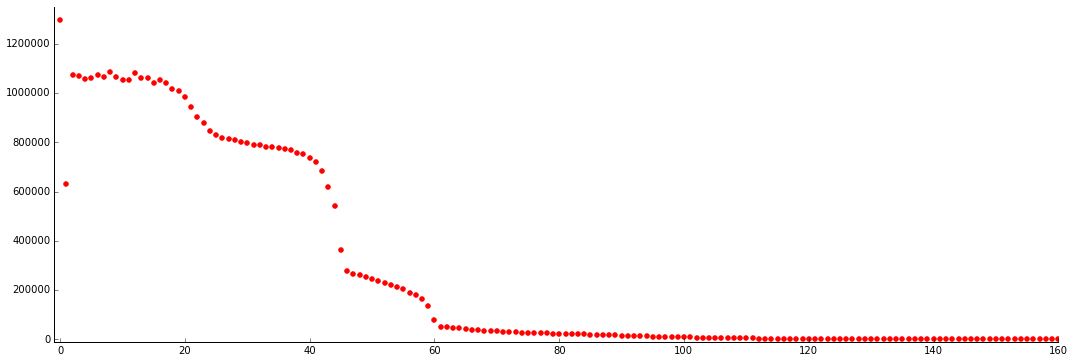

In [30]:
plt.figure(figsize=(18, 6))
plt.scatter(mins.minutes, mins.cnt, color = 'red')
plt.xlim(-1, 160)
plt.ylim(-10000, 1350000)
remove_border()
plt.show()